In [1]:
from tracemalloc import stop
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
sys.path.insert(1, "D:/AppProgPython/appprog/Lab4")
from df_functions import make_dataframe
from preprocess import preprocess_text

In [2]:
def visualization(epochs, train_losses, valid_losses, train_accuracy, valid_accuracy, batch_size, lr):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (lr={lr}, batch_size={batch_size})')
    plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (lr={lr}, batch_size={batch_size})')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (lr={lr}, batch_size={batch_size})')
    plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (lr={lr}, batch_size={batch_size})')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.tight_layout()
    plt.show()

In [3]:
def change_label(data:pd.DataFrame, rate: int) -> pd.DataFrame:
    """Changes labels in the dataframe"""
    data.dropna(inplace=True)
    labels = lambda x: 1 if x == rate else 0
    data['label'] = data['Рейтинг'].apply(labels)
    return data

In [4]:
def load_data(file_path: str) -> pd.DataFrame:
    """Loads data for csv file and preprocesses texts for vectorizing"""
    data = make_dataframe(file_path)
    data = preprocess_text(data)
    return data

In [5]:
def vectorizer(df: pd.DataFrame):
    """Vectorizes dataframe"""
    cv = CountVectorizer(max_features=1000, stop_words=stopwords.words('russian'))
    sparse_matrix = cv.fit_transform(df["Текст отзыва"]).toarray()
    return sparse_matrix

In [6]:
def split_data(all_data, df:pd.DataFrame):
    """Splits data into train and test samples"""
    text = np.array(df["label"])
    x_train, x_test, y_train, y_test = train_test_split(all_data, text)
    return x_train, x_test, y_train, y_test


Loading dataset

In [7]:
df = load_data('D:/AppProgPython/appprog/csv/final.csv')


Changing the label due to using the LogisticRegression

In [8]:
changed = change_label(df, 5)
vec = vectorizer(changed)
df.to_csv("D:/AppProgPython/appprog/csv/prepro.csv")
df.dropna(inplace =True)
df

,Абсолютный путь,Рейтинг,Текст отзыва,Количество слов,label
0,D:\AppProgPython\appprog\dataset\4\0000.txt,4,01 ноябрь решать пополнять свой счет банкомат ...,163,0
1,D:\AppProgPython\appprog\dataset\4\0001.txt,4,здраствовать 26.05 2023 заказывать дебетовый к...,179,0
2,D:\AppProgPython\appprog\dataset\4\0002.txt,4,добрый знак являться дружелюбный тон специалис...,130,0
3,D:\AppProgPython\appprog\dataset\4\0003.txt,4,выходить работа приходиться оформлять карта ал...,274,0
4,D:\AppProgPython\appprog\dataset\4\0004.txt,4,10 сентябрь приложение альфа банка совершать п...,199,0
...,...,...,...,...,...
995,D:\AppProgPython\appprog\dataset\5\0495.txt,5,30 сентябрь решать становиться клиент альфа-ба...,74,1
996,D:\AppProgPython\appprog\dataset\5\0496.txt,5,1 октябрь обращаться контактный центр альфа ба...,69,1
997,D:\AppProgPython\appprog\dataset\5\0497.txt,5,добрый день пользователь дебетовый карта альфа...,228,1
998,D:\AppProgPython\appprog\dataset\5\0498.txt,5,добрый день приходить уведомление мобильный пр...,194,1


Class LogisticRegression (our model)

In [9]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(1000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
x_train, x_tmp, y_train, y_tmp = split_data(vec, changed)
x_test, x_valid, y_test, y_valid = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)

In [10]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_valid)).float()
y_valid = Variable(torch.from_numpy(y_valid)).long()

Creating datasets for model

In [11]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

Learning rates and batch sizes

In [12]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 50
loss_values = []
models = []

Training loop

Learning rate: 0.0001
Batch size: 32
Epoch 1/50, Training Loss: 0.7015, Training Accuracy: 0.4987, Validation Loss: 0.7040, Validation Accuracy: 0.4800
Epoch 2/50, Training Loss: 0.6874, Training Accuracy: 0.5027, Validation Loss: 0.6961, Validation Accuracy: 0.5040
Epoch 3/50, Training Loss: 0.6747, Training Accuracy: 0.5293, Validation Loss: 0.6862, Validation Accuracy: 0.5440
Epoch 4/50, Training Loss: 0.6612, Training Accuracy: 0.5893, Validation Loss: 0.6746, Validation Accuracy: 0.5520
Epoch 5/50, Training Loss: 0.6450, Training Accuracy: 0.6907, Validation Loss: 0.6639, Validation Accuracy: 0.6080
Epoch 6/50, Training Loss: 0.6272, Training Accuracy: 0.7787, Validation Loss: 0.6534, Validation Accuracy: 0.6480
Epoch 7/50, Training Loss: 0.6082, Training Accuracy: 0.8080, Validation Loss: 0.6418, Validation Accuracy: 0.6560
Epoch 8/50, Training Loss: 0.5902, Training Accuracy: 0.8147, Validation Loss: 0.6297, Validation Accuracy: 0.6560
Epoch 9/50, Training Loss: 0.5703, Training

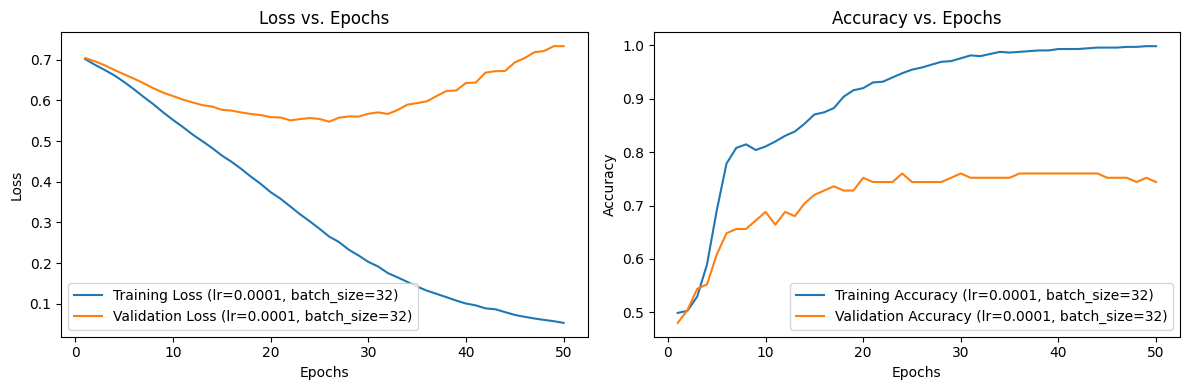

Learning rate: 0.0001
Batch size: 64
Epoch 1/50, Training Loss: 0.6908, Training Accuracy: 0.5173, Validation Loss: 0.6935, Validation Accuracy: 0.4800
Epoch 2/50, Training Loss: 0.6869, Training Accuracy: 0.5533, Validation Loss: 0.6915, Validation Accuracy: 0.5120
Epoch 3/50, Training Loss: 0.6832, Training Accuracy: 0.5827, Validation Loss: 0.6898, Validation Accuracy: 0.5440
Epoch 4/50, Training Loss: 0.6790, Training Accuracy: 0.6093, Validation Loss: 0.6879, Validation Accuracy: 0.5680
Epoch 5/50, Training Loss: 0.6755, Training Accuracy: 0.6400, Validation Loss: 0.6862, Validation Accuracy: 0.5680
Epoch 6/50, Training Loss: 0.6708, Training Accuracy: 0.6547, Validation Loss: 0.6840, Validation Accuracy: 0.5680
Epoch 7/50, Training Loss: 0.6656, Training Accuracy: 0.6747, Validation Loss: 0.6813, Validation Accuracy: 0.5840
Epoch 8/50, Training Loss: 0.6611, Training Accuracy: 0.6987, Validation Loss: 0.6787, Validation Accuracy: 0.5680
Epoch 9/50, Training Loss: 0.6542, Training

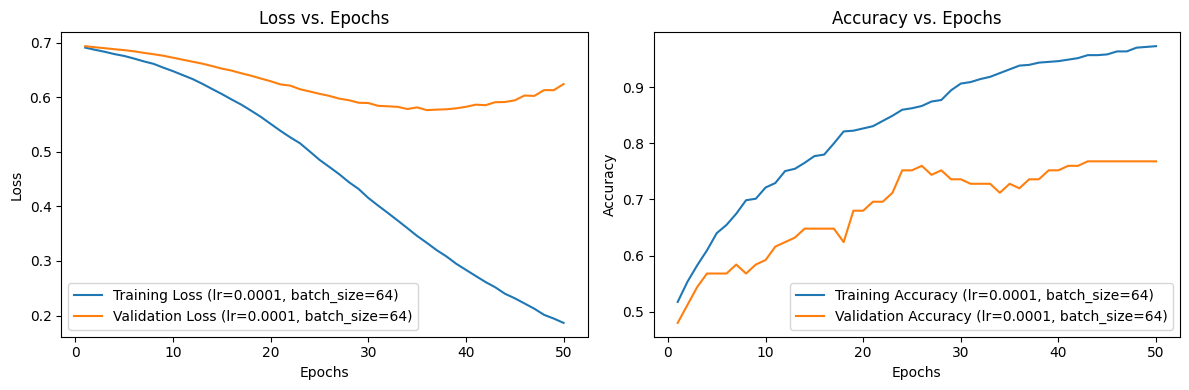

Learning rate: 0.0001
Batch size: 128
Epoch 1/50, Training Loss: 0.6936, Training Accuracy: 0.4907, Validation Loss: 0.6917, Validation Accuracy: 0.5200
Epoch 2/50, Training Loss: 0.6911, Training Accuracy: 0.5400, Validation Loss: 0.6909, Validation Accuracy: 0.5040
Epoch 3/50, Training Loss: 0.6889, Training Accuracy: 0.5867, Validation Loss: 0.6897, Validation Accuracy: 0.5360
Epoch 4/50, Training Loss: 0.6866, Training Accuracy: 0.6293, Validation Loss: 0.6884, Validation Accuracy: 0.5840
Epoch 5/50, Training Loss: 0.6842, Training Accuracy: 0.6733, Validation Loss: 0.6869, Validation Accuracy: 0.6240
Epoch 6/50, Training Loss: 0.6816, Training Accuracy: 0.7200, Validation Loss: 0.6849, Validation Accuracy: 0.6720
Epoch 7/50, Training Loss: 0.6786, Training Accuracy: 0.7587, Validation Loss: 0.6826, Validation Accuracy: 0.6800
Epoch 8/50, Training Loss: 0.6756, Training Accuracy: 0.7853, Validation Loss: 0.6802, Validation Accuracy: 0.6960
Epoch 9/50, Training Loss: 0.6718, Trainin

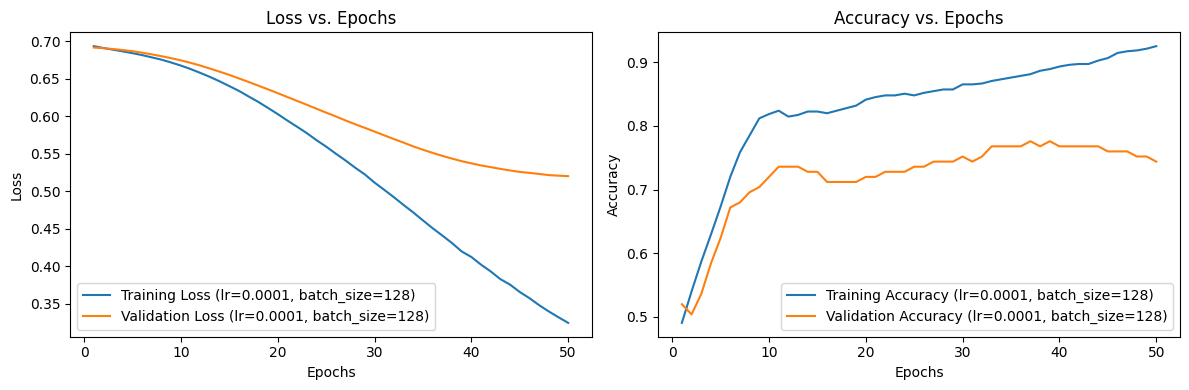

Learning rate: 0.001
Batch size: 32
Epoch 1/50, Training Loss: 0.6853, Training Accuracy: 0.5880, Validation Loss: 0.6616, Validation Accuracy: 0.6320
Epoch 2/50, Training Loss: 0.6224, Training Accuracy: 0.6973, Validation Loss: 0.5987, Validation Accuracy: 0.6880
Epoch 3/50, Training Loss: 0.4774, Training Accuracy: 0.8253, Validation Loss: 0.5411, Validation Accuracy: 0.7600
Epoch 4/50, Training Loss: 0.3218, Training Accuracy: 0.8933, Validation Loss: 0.5473, Validation Accuracy: 0.7760
Epoch 5/50, Training Loss: 0.2013, Training Accuracy: 0.9453, Validation Loss: 0.6301, Validation Accuracy: 0.7360
Epoch 6/50, Training Loss: 0.1182, Training Accuracy: 0.9747, Validation Loss: 0.7463, Validation Accuracy: 0.7600
Epoch 7/50, Training Loss: 0.0689, Training Accuracy: 0.9893, Validation Loss: 0.8121, Validation Accuracy: 0.7440
Epoch 8/50, Training Loss: 0.0422, Training Accuracy: 0.9947, Validation Loss: 0.9007, Validation Accuracy: 0.7440
Epoch 9/50, Training Loss: 0.0248, Training 

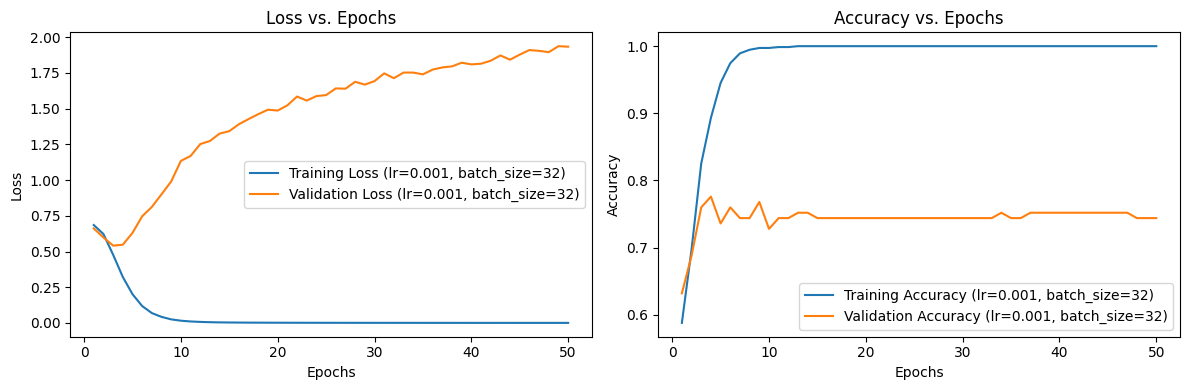

Learning rate: 0.001
Batch size: 64
Epoch 1/50, Training Loss: 0.6886, Training Accuracy: 0.5347, Validation Loss: 0.6693, Validation Accuracy: 0.6400
Epoch 2/50, Training Loss: 0.6254, Training Accuracy: 0.7813, Validation Loss: 0.6231, Validation Accuracy: 0.6880
Epoch 3/50, Training Loss: 0.5281, Training Accuracy: 0.8173, Validation Loss: 0.5703, Validation Accuracy: 0.7440
Epoch 4/50, Training Loss: 0.4148, Training Accuracy: 0.8400, Validation Loss: 0.5593, Validation Accuracy: 0.7280
Epoch 5/50, Training Loss: 0.3193, Training Accuracy: 0.8880, Validation Loss: 0.5587, Validation Accuracy: 0.7760
Epoch 6/50, Training Loss: 0.2247, Training Accuracy: 0.9373, Validation Loss: 0.5969, Validation Accuracy: 0.7360
Epoch 7/50, Training Loss: 0.1525, Training Accuracy: 0.9720, Validation Loss: 0.6641, Validation Accuracy: 0.7520
Epoch 8/50, Training Loss: 0.1024, Training Accuracy: 0.9813, Validation Loss: 0.7527, Validation Accuracy: 0.7680
Epoch 9/50, Training Loss: 0.0651, Training 

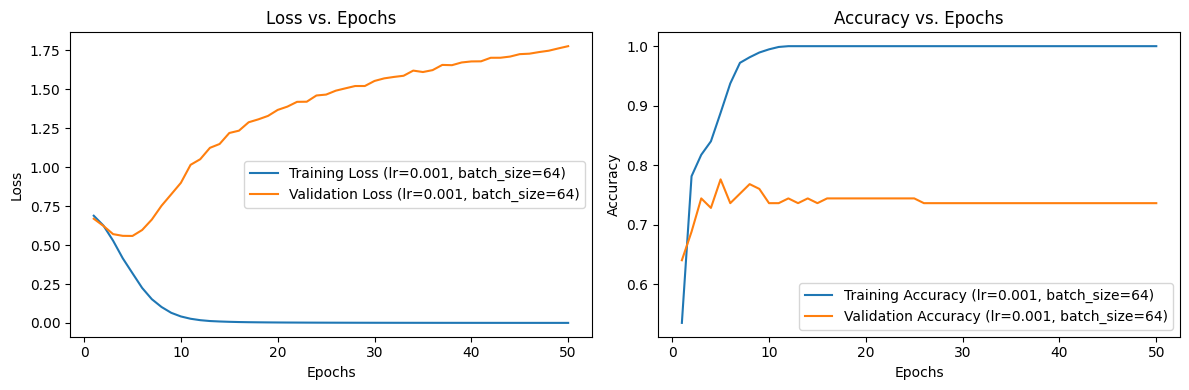

Learning rate: 0.001
Batch size: 128
Epoch 1/50, Training Loss: 0.6898, Training Accuracy: 0.5267, Validation Loss: 0.6775, Validation Accuracy: 0.5920
Epoch 2/50, Training Loss: 0.6517, Training Accuracy: 0.7373, Validation Loss: 0.6580, Validation Accuracy: 0.6160
Epoch 3/50, Training Loss: 0.6116, Training Accuracy: 0.7800, Validation Loss: 0.6387, Validation Accuracy: 0.6480
Epoch 4/50, Training Loss: 0.5673, Training Accuracy: 0.7973, Validation Loss: 0.6226, Validation Accuracy: 0.6720
Epoch 5/50, Training Loss: 0.5216, Training Accuracy: 0.8200, Validation Loss: 0.6067, Validation Accuracy: 0.6880
Epoch 6/50, Training Loss: 0.4669, Training Accuracy: 0.8667, Validation Loss: 0.5940, Validation Accuracy: 0.7280
Epoch 7/50, Training Loss: 0.4064, Training Accuracy: 0.8933, Validation Loss: 0.5883, Validation Accuracy: 0.7360
Epoch 8/50, Training Loss: 0.3454, Training Accuracy: 0.9173, Validation Loss: 0.5936, Validation Accuracy: 0.7280
Epoch 9/50, Training Loss: 0.2845, Training

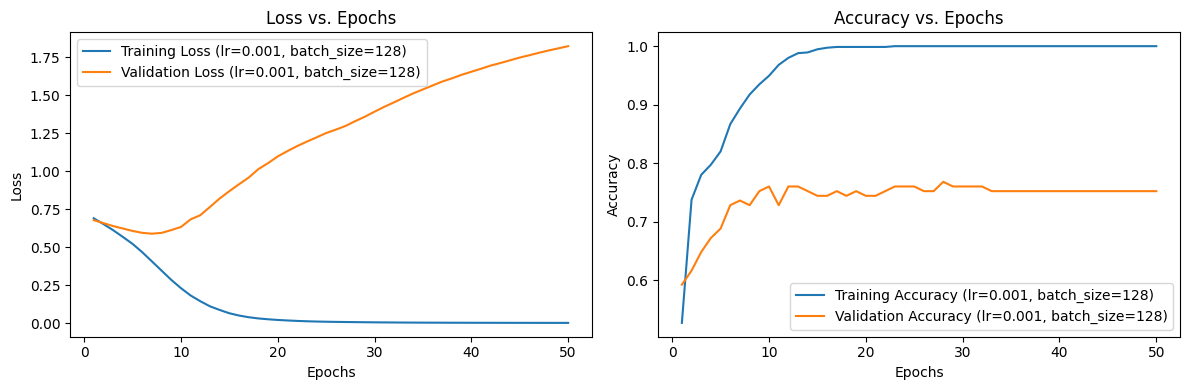

Learning rate: 0.01
Batch size: 32
Epoch 1/50, Training Loss: 0.6665, Training Accuracy: 0.6107, Validation Loss: 0.6116, Validation Accuracy: 0.6160
Epoch 2/50, Training Loss: 0.4072, Training Accuracy: 0.8147, Validation Loss: 0.6855, Validation Accuracy: 0.7360
Epoch 3/50, Training Loss: 0.2049, Training Accuracy: 0.9293, Validation Loss: 0.8050, Validation Accuracy: 0.7440
Epoch 4/50, Training Loss: 0.0698, Training Accuracy: 0.9827, Validation Loss: 1.4553, Validation Accuracy: 0.7200
Epoch 5/50, Training Loss: 0.0245, Training Accuracy: 0.9907, Validation Loss: 1.7738, Validation Accuracy: 0.7600
Epoch 6/50, Training Loss: 0.0089, Training Accuracy: 0.9987, Validation Loss: 1.8683, Validation Accuracy: 0.7360
Epoch 7/50, Training Loss: 0.0015, Training Accuracy: 1.0000, Validation Loss: 2.1938, Validation Accuracy: 0.7280
Epoch 8/50, Training Loss: 0.0005, Training Accuracy: 1.0000, Validation Loss: 2.3510, Validation Accuracy: 0.7280
Epoch 9/50, Training Loss: 0.0003, Training A

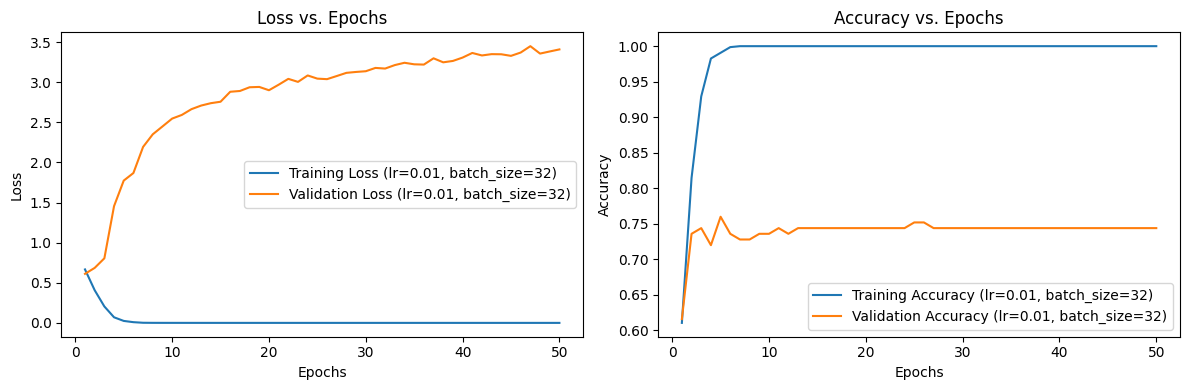

Learning rate: 0.01
Batch size: 64
Epoch 1/50, Training Loss: 0.6506, Training Accuracy: 0.6053, Validation Loss: 0.5743, Validation Accuracy: 0.7040
Epoch 2/50, Training Loss: 0.3984, Training Accuracy: 0.8253, Validation Loss: 0.6967, Validation Accuracy: 0.6720
Epoch 3/50, Training Loss: 0.1872, Training Accuracy: 0.9347, Validation Loss: 0.8826, Validation Accuracy: 0.7520
Epoch 4/50, Training Loss: 0.0594, Training Accuracy: 0.9787, Validation Loss: 1.3318, Validation Accuracy: 0.7440
Epoch 5/50, Training Loss: 0.0148, Training Accuracy: 0.9973, Validation Loss: 1.5831, Validation Accuracy: 0.7360
Epoch 6/50, Training Loss: 0.0029, Training Accuracy: 1.0000, Validation Loss: 1.7698, Validation Accuracy: 0.7360
Epoch 7/50, Training Loss: 0.0010, Training Accuracy: 1.0000, Validation Loss: 1.9698, Validation Accuracy: 0.7280
Epoch 8/50, Training Loss: 0.0005, Training Accuracy: 1.0000, Validation Loss: 2.0815, Validation Accuracy: 0.7200
Epoch 9/50, Training Loss: 0.0003, Training A

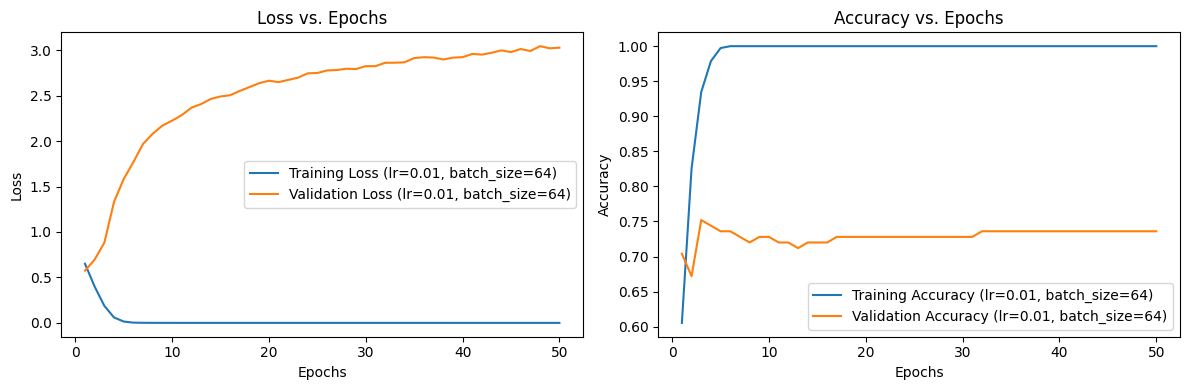

Learning rate: 0.01
Batch size: 128
Epoch 1/50, Training Loss: 0.6444, Training Accuracy: 0.6307, Validation Loss: 0.5573, Validation Accuracy: 0.7440
Epoch 2/50, Training Loss: 0.3874, Training Accuracy: 0.8373, Validation Loss: 0.7976, Validation Accuracy: 0.7280
Epoch 3/50, Training Loss: 0.1996, Training Accuracy: 0.9213, Validation Loss: 0.8818, Validation Accuracy: 0.7200
Epoch 4/50, Training Loss: 0.0854, Training Accuracy: 0.9760, Validation Loss: 1.1547, Validation Accuracy: 0.7120
Epoch 5/50, Training Loss: 0.0318, Training Accuracy: 0.9920, Validation Loss: 1.4929, Validation Accuracy: 0.7440
Epoch 6/50, Training Loss: 0.0072, Training Accuracy: 0.9973, Validation Loss: 1.7728, Validation Accuracy: 0.7360
Epoch 7/50, Training Loss: 0.0048, Training Accuracy: 0.9987, Validation Loss: 2.0204, Validation Accuracy: 0.7200
Epoch 8/50, Training Loss: 0.0018, Training Accuracy: 1.0000, Validation Loss: 2.2181, Validation Accuracy: 0.7200
Epoch 9/50, Training Loss: 0.0009, Training 

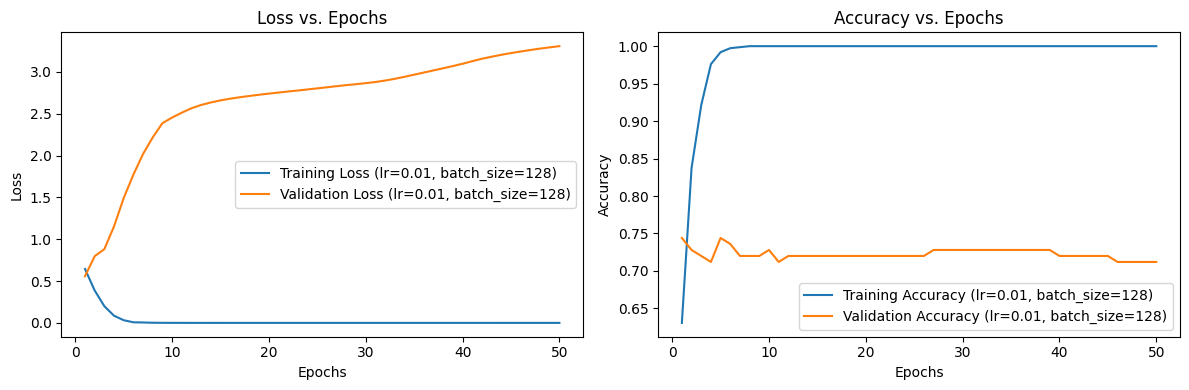

Test Accuracy: 0.7040


In [13]:
for lr in learning_rates:
    for bs in batch_sizes:
        model = LogisticRegression()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)
        
        print(f'Learning rate: {lr}')
        print(f'Batch size: {bs}')
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

        # Training loop
        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in range(epochs):
            model.train()

            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracy.append(correct_train / total_train)

            # Validation
            model.eval()

            running_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(running_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)
                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        visualization(epochs, train_losses, valid_losses, train_accuracy, valid_accuracy, bs, lr)

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')


Repeated initialization of the model with the normal learning rate and batch size

In [21]:
batch_size = 64
lr = 0.0001
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

epochs = 20

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

    # Validation
    model.eval()

    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()
        valid_losses.append(running_loss / len(valid_loader))
        valid_accuracy.append(correct_valid / total_valid)
        print(f'Epoch {epoch + 1}/{epochs}, '
            f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
            f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')

Epoch 1/20, Training Loss: 0.6920, Training Accuracy: 0.5040, Validation Loss: 0.6886, Validation Accuracy: 0.6240
Epoch 2/20, Training Loss: 0.6867, Training Accuracy: 0.6053, Validation Loss: 0.6863, Validation Accuracy: 0.6320
Epoch 3/20, Training Loss: 0.6822, Training Accuracy: 0.6813, Validation Loss: 0.6838, Validation Accuracy: 0.6480
Epoch 4/20, Training Loss: 0.6770, Training Accuracy: 0.7467, Validation Loss: 0.6809, Validation Accuracy: 0.6720
Epoch 5/20, Training Loss: 0.6713, Training Accuracy: 0.7773, Validation Loss: 0.6779, Validation Accuracy: 0.7120
Epoch 6/20, Training Loss: 0.6654, Training Accuracy: 0.8000, Validation Loss: 0.6741, Validation Accuracy: 0.7200
Epoch 7/20, Training Loss: 0.6582, Training Accuracy: 0.8133, Validation Loss: 0.6700, Validation Accuracy: 0.6880
Epoch 8/20, Training Loss: 0.6500, Training Accuracy: 0.8293, Validation Loss: 0.6650, Validation Accuracy: 0.7040
Epoch 9/20, Training Loss: 0.6407, Training Accuracy: 0.8333, Validation Loss: 0

Saving the model

In [22]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pth')

creating sample

In [23]:
sample = "единственный банк который показывать мобильный приложение сумма дата платеж \
    сохранение беспроцентный период отражаться платеж "" -  лишь минимальный платеж \
    который обеспечивать сохранение беспроцентный период необходимо очень тщательно \
    отслеживать платеж самостоятельно опираться собственный расчет банк предупреждать \
    подсказывать обязательно радость начислять штрафной процент вылет грейс \
    поддержка также нелегко получать необходимый информация прямой вопрос \
    отвечать пространный следовать рекомендация штрафной процент вылет грейс обеспечивать"
max_words = 1000
cv = CountVectorizer(max_features=max_words, stop_words=stopwords.words('russian'))
sparse_matrix = cv.fit_transform(np.array([sample])).toarray()
if sparse_matrix.shape[1] < 1000:
    sparse_matrix = np.pad(sparse_matrix, ((0, 0), (0, 1000 - sparse_matrix.shape[1])))
sparse_matrix.shape

(1, 1000)

Loading checkpoint of the model

In [24]:
review = Variable(torch.from_numpy(sparse_matrix)).float()
model = LogisticRegression()
load_checkpoint = torch.load('model.pth')
model.load_state_dict(load_checkpoint['model_state_dict'])
optimizer.load_state_dict(load_checkpoint['optimizer_state_dict'])
epoch = load_checkpoint['epoch']

model.eval()

LogisticRegression(
  (linear1): Linear(in_features=1000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=2, bias=True)
)

Predicting class of the sample

In [25]:
with torch.no_grad():
    output = model(review)
    print('output: ', output)


predict = torch.argmax(output).item()

print(f"Предсказанный класс: {predict}")

output:  tensor([[0.1445, 0.3348]])
Предсказанный класс: 1
